In [35]:
import csv
path_to_chest_imagenome = "/u/home/tanida/datasets/chest-imagenome-dataset"

In [36]:
def get_images_to_avoid():
    path_to_images_to_avoid = os.path.join(path_to_chest_imagenome, "silver_dataset", "splits", "images_to_avoid.csv")

    image_ids_to_avoid = set()

    with open(path_to_images_to_avoid) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")

        # skip the first line (i.e. the header line)
        next(csv_reader)

        for row in csv_reader:
            image_id = row[2]
            image_ids_to_avoid.add(image_id)

    return image_ids_to_avoid

In [37]:
image_ids_to_avoid = get_images_to_avoid()

In [41]:
"5cae71aa-99bb4662-41ef629e-7e89308c-5831ff9c" in image_ids_to_avoid

False

In [1]:
import spacy
nlp = spacy.load('en_core_web_trf') # Load the English Model

In [11]:
text = "hello \n\n this is a test.\t\t this sentence   will become cleaned."
print(text)

hello 

 this is a test.		 this sentence   will become cleaned.


In [34]:
type(nlp)

spacy.lang.en.English

In [15]:
new_text = " ".join(text.split())
print(new_text)

hello this is a test. this sentence will become cleaned.


In [26]:
doc1 = nlp(new_text)
sent = next(iter(doc1.sents))
type(sent)

spacy.tokens.span.Span

In [33]:
doc1 = nlp(new_text)
new_text_capitalized = " ".join(sent.text[0].upper() + sent.text[1:] for sent in doc1.sents)
new_text_capitalized

'Hello this is a test. This sentence will become cleaned.'

In [4]:
string1 = "Previous mild pulmonary edema and possible concurrent pneumonia has all cleared. Heart is top-normal size, improved, and pleural effusions have resolved. Right hilar vessels are still enlarged, perhaps due to pulmonary arterial hypertension."
doc = nlp(string1)

In [5]:
for sent in doc.sents:
    print(sent)

Previous mild pulmonary edema and possible concurrent pneumonia has all cleared.
Heart is top-normal size, improved, and pleural effusions have resolved.
Right hilar vessels are still enlarged, perhaps due to pulmonary arterial hypertension.


In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
writer = SummaryWriter(log_dir="/u/home/tanida/region-guided-chest-x-ray-report-generation/src/tensorboard_test")

In [4]:
from ast import literal_eval
from copy import deepcopy
import logging
import os
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from datasets import Dataset
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import torchmetrics
from transformers import GPT2Tokenizer
from tqdm import tqdm

from src.dataset.constants import ANATOMICAL_REGIONS
from src.full_model.custom_collator import CustomCollator
from src.full_model.custom_dataset import CustomDataset
from src.full_model.report_generation_model import ReportGenerationModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(level=logging.INFO, format="[%(levelname)s]: %(message)s")
log = logging.getLogger(__name__)

# set the seed value for reproducibility
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# define configurations for training run
RUN = 1
# can be useful to add additional information to run_config.txt file
RUN_COMMENT = """Train full model with ResNet object detector"""
IMAGE_INPUT_SIZE = 512
PERCENTAGE_OF_TRAIN_SET_TO_USE = 0.0001
PERCENTAGE_OF_VAL_SET_TO_USE = 0.001
BATCH_SIZE = 2
NUM_WORKERS = 12
EPOCHS = 20
LR = 1e-4
EVALUATE_EVERY_K_STEPS = 5000  # how often to evaluate the model on the validation set and log metrics to tensorboard (additionally, model will always be evaluated at end of epoch)
PATIENCE_LR_SCHEDULER = 5  # number of evaluations to wait for val loss to reduce before lr is reduced by 1e-1
NUM_BEAMS = 4
MAX_NUM_TOKENS_GENERATE = 300
NUM_BATCHES_OF_GENERATED_SENTENCES_TO_SAVE_TO_FILE = 6  # save num_batches_of_... worth of generated sentences with their gt reference phrases to a txt file
NUM_SENTENCES_TO_GENERATE_FOR_EVALUATION = 300  # for evaluation of BLEU/BERTScore
NUM_IMAGES_TO_PLOT = 4

In [5]:
def get_transforms(dataset: str):
    # see compute_mean_std_dataset.py in src/dataset_bounding_boxes
    mean = 0.471
    std = 0.302

    # use albumentations for Compose and transforms
    # augmentations are applied with prob=0.5
    # since Affine translates and rotates the image, we also have to do the same with the bounding boxes, hence the bbox_params arugment
    train_transforms = A.Compose(
        [
            # we want the long edge of the image to be resized to IMAGE_INPUT_SIZE, and the short edge of the image to be padded to IMAGE_INPUT_SIZE on both sides,
            # such that the aspect ratio of the images are kept, while getting images of uniform size (IMAGE_INPUT_SIZE x IMAGE_INPUT_SIZE)
            # LongestMaxSize: resizes the longer edge to IMAGE_INPUT_SIZE while maintaining the aspect ratio
            # INTER_AREA works best for shrinking images
            A.LongestMaxSize(max_size=IMAGE_INPUT_SIZE, interpolation=cv2.INTER_AREA),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
            A.GaussianBlur(blur_limit=(1, 1)),
            A.ColorJitter(hue=0.0, saturation=0.0),
            A.Sharpen(alpha=(0.1, 0.2), lightness=0.0),
            # randomly (by default prob=0.5) translate and rotate image
            # mode and cval specify that black pixels are used to fill in newly created pixels
            # translate between -2% and 2% of the image height/width, rotate between -2 and 2 degrees
            A.Affine(mode=cv2.BORDER_CONSTANT, cval=0, translate_percent=(-0.02, 0.02), rotate=(-2, 2)),
            A.GaussNoise(),
            # PadIfNeeded: pads both sides of the shorter edge with 0's (black pixels)
            A.PadIfNeeded(min_height=IMAGE_INPUT_SIZE, min_width=IMAGE_INPUT_SIZE, border_mode=cv2.BORDER_CONSTANT),
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]),
    )

    # don't apply data augmentations to val and test set
    val_test_transforms = A.Compose(
        [
            A.LongestMaxSize(max_size=IMAGE_INPUT_SIZE, interpolation=cv2.INTER_AREA),
            A.PadIfNeeded(min_height=IMAGE_INPUT_SIZE, min_width=IMAGE_INPUT_SIZE, border_mode=cv2.BORDER_CONSTANT),
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]),
    )

    if dataset == "train":
        return train_transforms
    else:
        return val_test_transforms


def get_tokenized_datasets(tokenizer, raw_train_dataset, raw_val_dataset):
    def tokenize_function(example):
        phrases = example["bbox_phrases"]  # List[str]
        bos_token = "<|endoftext|>"  # note: in the GPT2 tokenizer, bos_token = eos_token = "<|endoftext|>"
        eos_token = "<|endoftext|>"

        phrases_with_special_tokens = [bos_token + phrase + eos_token for phrase in phrases]

        # the tokenizer will return input_ids of type List[List[int]] and attention_mask of type List[List[int]]
        return tokenizer(phrases_with_special_tokens, truncation=True, max_length=1024)

    tokenized_train_dataset = raw_train_dataset.map(tokenize_function)
    tokenized_val_dataset = raw_val_dataset.map(tokenize_function)

    # tokenized datasets will consist of the columns
    #   - mimic_image_file_path
    #   - bbox_coordinates (List[List[int]])
    #   - bbox_labels (List[int])
    #   - bbox_phrases (List[str])
    #   - input_ids (List[List[int]])
    #   - attention_mask (List[List[int]])
    #   - bbox_phrase_exists (List[bool])
    #   - bbox_is_abnormal (List[bool])

    return tokenized_train_dataset, tokenized_val_dataset


def get_tokenizer():
    checkpoint = "healx/gpt-2-pubmed-medium"
    tokenizer = GPT2Tokenizer.from_pretrained(checkpoint)
    tokenizer.pad_token = tokenizer.eos_token

    return tokenizer


def get_datasets():
    path_dataset_object_detector = "/u/home/tanida/datasets/dataset-for-full-model-original-bbox-coordinates"

    usecols = [
        "mimic_image_file_path",
        "bbox_coordinates",
        "bbox_labels",
        "bbox_phrases",
        "bbox_phrase_exists",
        "bbox_is_abnormal",
    ]

    # all of the columns below are stored as strings in the csv_file
    # however, as they are actually lists, we apply the literal_eval func to convert them to lists
    converters = {
        "bbox_coordinates": literal_eval,
        "bbox_labels": literal_eval,
        "bbox_phrases": literal_eval,
        "bbox_phrase_exists": literal_eval,
        "bbox_is_abnormal": literal_eval,
    }

    datasets_as_dfs = {dataset: os.path.join(path_dataset_object_detector, dataset) + ".csv" for dataset in ["train", "valid"]}

    datasets_as_dfs = {dataset: pd.read_csv(csv_file_path, usecols=usecols, converters=converters) for dataset, csv_file_path in datasets_as_dfs.items()}

    # bbox_phrases is a list of str
    # replace each bbox_phrase that is empty (i.e. "") by "#"
    # this is done such that model learns to generate the "#" symbol instead of "" for empty sentences
    # this is done because generated sentences that are "" (i.e. have len = 0) will cause problems when computing e.g. Bleu scores
    for dataset_df in datasets_as_dfs.values():
        dataset_df["bbox_phrases"] = dataset_df["bbox_phrases"].apply(lambda bbox_phrases: [phrase if len(phrase) != 0 else "#" for phrase in bbox_phrases])

    total_num_samples_train = len(datasets_as_dfs["train"])
    total_num_samples_val = len(datasets_as_dfs["valid"])

    # compute new number of samples for both train and val
    new_num_samples_train = int(PERCENTAGE_OF_TRAIN_SET_TO_USE * total_num_samples_train)
    new_num_samples_val = int(PERCENTAGE_OF_VAL_SET_TO_USE * total_num_samples_val)

    log.info(f"Train: {new_num_samples_train} images")
    log.info(f"Val: {new_num_samples_val} images")

    # limit the datasets to those new numbers
    datasets_as_dfs["train"] = datasets_as_dfs["train"][:new_num_samples_train]
    datasets_as_dfs["valid"] = datasets_as_dfs["valid"][:new_num_samples_val]

    raw_train_dataset = Dataset.from_pandas(datasets_as_dfs["train"])
    raw_val_dataset = Dataset.from_pandas(datasets_as_dfs["valid"])

    return raw_train_dataset, raw_val_dataset

In [6]:
raw_train_dataset, raw_val_dataset = get_datasets()

tokenizer = get_tokenizer()

# tokenize the raw datasets
tokenized_train_dataset, tokenized_val_dataset = get_tokenized_datasets(tokenizer, raw_train_dataset, raw_val_dataset)

train_transforms = get_transforms("train")
val_transforms = get_transforms("val")

train_dataset_complete = CustomDataset("train", tokenized_train_dataset, train_transforms)
val_dataset_complete = CustomDataset("val", tokenized_val_dataset, val_transforms)

[INFO]: Train: 15 images
[INFO]: Val: 22 images
[WARNING]: Parameter 'function'=<function get_tokenized_datasets.<locals>.tokenize_function at 0x7fa7c19a4dc0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/15 [00:00<?, ?ex/s]

  0%|          | 0/22 [00:00<?, ?ex/s]

In [7]:
first_sample = train_dataset_complete[0]

In [8]:
bboxes_plt = first_sample["bbox_coordinates"][:6]
bboxes_plt

tensor([[ 75.5501,  25.6522, 224.0084, 339.7856],
        [122.7397,  32.7748, 255.9031, 129.5674],
        [106.3008, 128.6417, 223.3677, 204.8249],
        [ 75.5501, 203.9118, 234.3036, 339.8567],
        [202.2811, 113.2882, 223.4671, 218.4982],
        [143.5691,  26.0661, 253.6645,  81.6965]])

In [9]:
cls_labels = first_sample["bbox_labels"][:6]
cls_labels

tensor([1, 2, 3, 4, 5, 6])

In [10]:
def plot_box(box, ax, clr, linestyle):
    x0, y0, x1, y1 = box
    h = y1 - y0
    w = x1 - x0
    ax.add_artist(
      plt.Rectangle(
          xy=(x0, y0),
          height=h,
          width=w,
          fill=False,
          color=clr,
          linewidth=1,
          linestyle=linestyle
      )
    )

In [33]:
import io
from PIL import Image

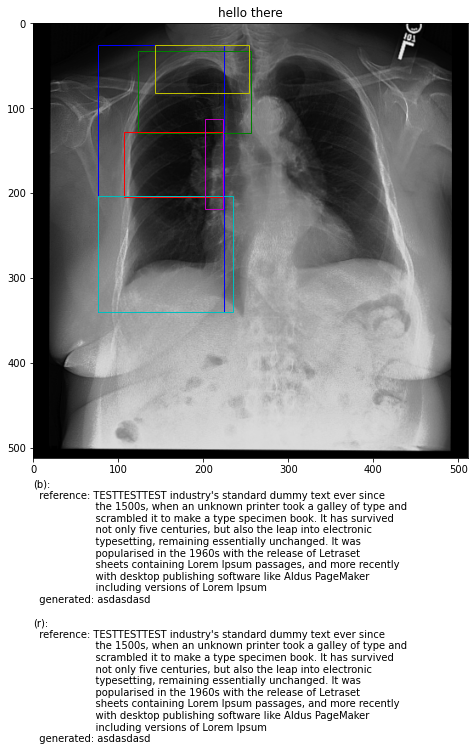

In [52]:
image = first_sample["image"].numpy().transpose(1, 2, 0)
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
plt.imshow(image, cmap='gray')
plt.axis("on")

reference = "TESTTESTTEST industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum"
generated = "asdasdasd"

def transform_text(text):
    max_line_length = 50
    if len(text) < max_line_length:
        return text

    words = text.split()
    transformed_text = ""
    current_line_length = 0
    prefix_for_alignment = "\n" + " " * 20
    for word in words:
        if len(word) + current_line_length > max_line_length:
            word = f"{prefix_for_alignment}{word}"
            current_line_length = -len(prefix_for_alignment)

        current_line_length += len(word)
        transformed_text += word + " "

    return transformed_text

reference = transform_text(reference)
generated = transform_text(generated)
txt = f"(b):\n  reference: {reference}\n  generated: {generated}\n\n(r):\n  reference: {reference}\n  generated: {generated}"

colors = ["b", "g", "r", "c", "m", "y"]
for four_bboxes, color in zip(bboxes_plt, colors):
    plot_box(four_bboxes, ax, clr=color, linestyle="solid")

ax.set_title("hello there")
plt.xlabel(txt, loc="left")

buf = io.BytesIO()
fig.savefig(buf, bbox_inches="tight")
buf.seek(0)
im = Image.open(buf)
img_new = np.asarray(im)[...,:3]

In [53]:
writer.add_image("my_image", img_new, global_step=260, dataformats="HWC")

In [1]:
from ast import literal_eval
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import torch

from src.object_detector.custom_image_dataset_object_detector import CustomImageDataset

In [2]:
# define configurations for training run
RUN = 0
PERCENTAGE_OF_TRAIN_SET_TO_USE = 0.08
PERCENTAGE_OF_VAL_SET_TO_USE = 0.1
BATCH_SIZE = 32
NUM_WORKERS = 12
EPOCHS = 30
LR = 1e-2
EVALUATE_EVERY_K_STEPS = 3500  # how often to evaluate the model on the validation set and log metrics to tensorboard (additionally, model will always be evaluated at end of epoch)
PATIENCE = 10  # number of evaluations to wait before early stopping
PATIENCE_LR_SCHEDULER = 3  # number of evaluations to wait for val loss to reduce before lr is reduced by 1e-1


In [3]:
def get_datasets_as_dfs():
    path_dataset_object_detector = "/u/home/tanida/datasets/dataset-for-full-model-50"

    usecols = ["mimic_image_file_path", "bbox_coordinates", "bbox_labels"]

    # since bbox_coordinates and labels are stored as strings in the csv_file, we have to apply 
    # the literal_eval func to convert them to python lists
    converters = {"bbox_coordinates": literal_eval, "bbox_labels": literal_eval}

    datasets_as_dfs = {dataset: os.path.join(path_dataset_object_detector, f"{dataset}-50") + ".csv" for dataset in ["train", "valid", "test"]}
    datasets_as_dfs = {dataset: pd.read_csv(csv_file_path, usecols=usecols, converters=converters) for dataset, csv_file_path in datasets_as_dfs.items()}

    total_num_samples_train = len(datasets_as_dfs["train"])
    total_num_samples_val = len(datasets_as_dfs["valid"])

    # compute new number of samples for both train and val
    new_num_samples_train = int(PERCENTAGE_OF_TRAIN_SET_TO_USE * total_num_samples_train)
    new_num_samples_val = int(PERCENTAGE_OF_VAL_SET_TO_USE * total_num_samples_val)

    # limit the datasets to those new numbers
    datasets_as_dfs["train"] = datasets_as_dfs["train"][:new_num_samples_train]
    datasets_as_dfs["valid"] = datasets_as_dfs["valid"][:new_num_samples_val]

    return datasets_as_dfs


In [4]:
datasets_as_dfs = get_datasets_as_dfs()

In [5]:
def get_transforms(dataset: str):
    # note: transforms are applied to the already resized (to 224x224) and padded images 
    # (see __getitem__ method of custom dataset class)!
    mean = 0.471
    std = 0.302

    # use albumentations for Compose and transforms
    train_transforms = A.Compose([
        # A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
        # A.GaussianBlur(blur_limit=(1, 1)),
        # A.ColorJitter(),
        # A.Sharpen(alpha=(0.1, 0.2), lightness=0.0),
        # A.Affine(mode=cv2.BORDER_CONSTANT, cval=0, translate_percent=(-0.02, 0.02), rotate=(-20, 20), p=1.0),
        A.Affine(mode=cv2.BORDER_CONSTANT, cval=0, translate_percent=(-0.10, 0), p=1),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=['class_labels']))

    val_transforms = A.Compose([
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=['class_labels']))

    if dataset == "train":
        return train_transforms
    else:
        return val_transforms



In [6]:
train_transforms = get_transforms("train")
val_transforms = get_transforms("val")

In [7]:
train_dataset = CustomImageDataset(datasets_as_dfs["train"], train_transforms)
val_dataset = CustomImageDataset(datasets_as_dfs["valid"], val_transforms)

In [8]:
first_sample = train_dataset[0]

In [9]:
bboxes_plt = first_sample["boxes"][:6]
bboxes_plt

tensor([[ 0.0000,  0.0000, 30.7643, 33.4926],
        [ 0.0000,  0.0000, 90.7643, 33.4926],
        [ 0.0000,  0.0000, 90.7643, 33.4926]])

In [10]:
cls_labels = first_sample["labels"][:6]
cls_labels

tensor([19, 33, 35])

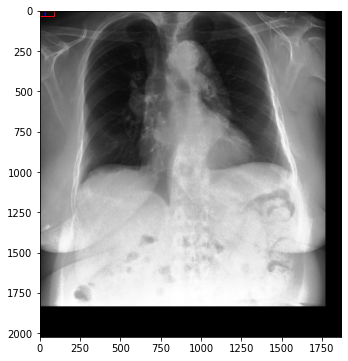

In [13]:
# image = train_dataset[0]["image"]
image = first_sample["image"].cpu().numpy().transpose(1, 2, 0)
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
plt.imshow(image, cmap='gray')

colors = ["b", "g", "r", "c", "m", "y"]
for four_bboxes, color in zip(bboxes_plt, colors):
    plot_box(four_bboxes, ax, clr=color, linestyle="solid")

TypeError: Invalid shape (1, 2022, 1870) for image data

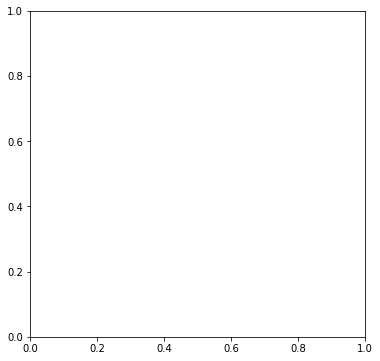

In [13]:
image = first_sample["image"]
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
# plt.imshow(image.cpu().numpy().transpose(1, 2, 0), cmap='gray')
plt.imshow(image, cmap='gray', aspect='auto', interpolation='nearest')

colors = ["b", "g", "r", "c", "m", "y"]
for four_bboxes, color in zip(bboxes_plt, colors):
    plot_box(four_bboxes, ax, clr=color, linestyle="solid")

In [12]:
def plot_box(box, ax, clr, linestyle):
    x0, y0, x1, y1 = box
    h = y1 - y0
    w = x1 - x0
    ax.add_artist(
      plt.Rectangle(
          xy=(x0, y0),
          height=h,
          width=w,
          fill=False,
          color=clr,
          linewidth=1,
          linestyle=linestyle
      )
    )

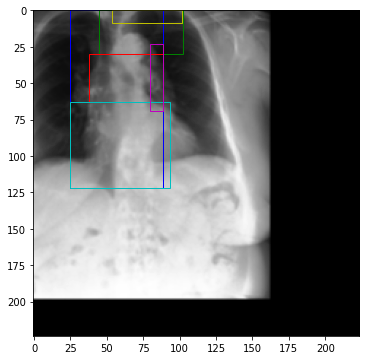

In [13]:
image = train_dataset[0]["image"]
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
plt.imshow(image.cpu().numpy().transpose(1, 2, 0), cmap='gray')

colors = ["b", "g", "r", "c", "m", "y"]
for four_bboxes, color in zip(bboxes_plt, colors):
    plot_box(four_bboxes, ax, clr=color, linestyle="solid")

In [8]:
import pandas as pd
import numpy as np
import os, re 
import time
from numpy import genfromtxt
import json
import cv2
import matplotlib
import matplotlib.pyplot as plt
print(matplotlib.__version__)
%matplotlib inline

3.5.2


In [9]:
from src.dataset_bounding_boxes.constants import ANATOMICAL_REGIONS

In [10]:
def checkCoord(x,dim):
    if x < 0:
        x = 0
    if x > dim:
        x = dim
    return x

# Draw bbox on image -- has the option to save image with not margin for annotation
def drawBbox(image, x1, y1, x2, y2, bbox_name=None, phrases=None, plot=True,exportfilepath=None):
    image = image.copy()
    stroke = 10
    w,h = image.shape
    x1 = checkCoord(int(x1), w)
    y1 = checkCoord(int(y1), h)
    x2 = checkCoord(int(x2), w)
    y2 = checkCoord(int(y2), h)
    image[y1:y1 + stroke, x1:x2] = 3
    image[y2:y2 + stroke, x1:x2] = 3
    image[y1:y2, x1:x1 + stroke] = 3
    image[y1:y2, x2:x2 + stroke] = 3
    
    if plot:
        dpi = 3000
        # What size does the figure need to be in inches to fit the image?
        height, width = image.shape
        figsize = width / float(dpi), height / float(dpi)
        figsize = width / 30., height / 30.
        # To make a figure without the frame :
#         fig = plt.figure(frameon=False) # gives a bug in the plt 3.1.0 + this jupyter notebook env for some reason
        fig = plt.figure()
        fig.set_size_inches(figsize)
        # To make the content fill the whole figure
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        
        if bbox_name:
            ax.set_title(bbox_name)
            
        if phrases:
            fig.text(.5, .05, phrases, ha='center')

        # Then draw your image on it :
        ax.imshow(image, cmap='gray', aspect='auto', interpolation='nearest')

        # Ensure we're displaying with square pixels and the right extent.
        # This is optional if you haven't called `plot` or anything else that might
        # change the limits/aspect.
        ax.set(xlim=[-0.5, width - 0.5], ylim=[height - 0.5, -0.5], aspect='auto')
        
    if exportfilepath!=None:
        fig.savefig(exportfilepath, dpi=dpi, transparent=True)
        
#     if plot:
#         plt.figure(figsize=(10, 10))
#         plt.imshow(image, cmap='gray')
#         # plt.close() #or won't show up in notebook if run
#     if exportfilepath!=None:
#         fig.savefig(exportfilepath, dpi=80, transparent=True)
    return image


# visualize an object given image_id and name
def plot_object(image, bboxes, labels, index):
    bbox = bboxes[index]
    class_label = labels[index]

    for region_name, id in ANATOMICAL_REGIONS.items():
        if (class_label-1) == id:
            bbox_name = region_name

    x1 = bbox[0]
    y1 = bbox[1]
    x2 = bbox[2]
    y2 = bbox[3]

    drawBbox(image, x1, y1, x2, y2, bbox_name, None)

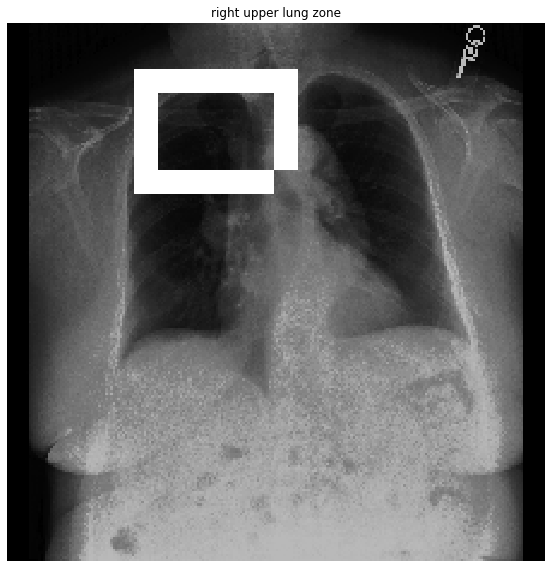

In [39]:
plot_object(single_image.squeeze().numpy(), bboxes, labels, 1)

In [9]:
from object_detector import ObjectDetector

In [10]:
model = ObjectDetector(return_feature_vectors=True)
path_to_best_object_detector_weights = "/u/home/tanida/runs/object_detector/run_2/weights/last_epoch.pth"
model.load_state_dict(torch.load(path_to_best_object_detector_weights))

<All keys matched successfully>

In [11]:
model.train()

ObjectDetector(
  (backbone): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [12]:
first_image = train_dataset[0]["image"]
second_image = train_dataset[1]["image"]
third_image = train_dataset[2]["image"]
fourth_image = train_dataset[3]["image"]

In [13]:
first_targets = train_dataset[0]
second_targets = train_dataset[1]
third_targets = train_dataset[2]
fourth_targets = train_dataset[3]

In [14]:
first_targets.pop("image")
second_targets.pop("image")
third_targets.pop("image")
fourth_targets.pop("image")

tensor([[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         ...,
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]]])

In [15]:
targets = [first_targets, second_targets, third_targets, fourth_targets]

In [16]:
batch = torch.stack([first_image, second_image, third_image, fourth_image], dim=0)
losses, top_region_features, class_predicted = model(batch, targets)

In [17]:
top_region_features.shape

torch.Size([4, 36, 1024])

In [18]:
top_region_features

tensor([[[-0.3276, -0.2435, -0.1774,  ..., -1.2742, -0.6646, -0.5057],
         [-0.4279, -0.1707, -0.1411,  ..., -1.2598, -0.2863, -0.8114],
         [-0.3462, -0.1863, -0.1983,  ..., -1.8802, -0.7135, -1.1738],
         ...,
         [-0.5073, -0.2246, -0.1548,  ..., -0.5774, -0.9902, -0.6890],
         [-0.4648, -0.2993, -0.1247,  ..., -0.4067, -0.3836, -0.5248],
         [ 0.1505, -0.4762, -0.1538,  ..., -0.3445,  0.5975, -0.7714]],

        [[-0.4782, -0.1650, -0.1768,  ..., -0.3332, -0.4935, -0.3516],
         [-0.6063, -0.1616, -0.1589,  ...,  0.1710,  0.1235, -0.0887],
         [-0.6364, -0.0964, -0.1852,  ..., -0.3443, -0.5280, -0.2215],
         ...,
         [-0.4740, -0.1711, -0.1740,  ..., -0.4633, -0.9478, -0.7736],
         [-0.4709, -0.2382, -0.1610,  ..., -0.4803, -0.5084, -0.7867],
         [-0.3489, -0.3100, -0.1799,  ...,  0.1759,  0.3242, -0.9681]],

        [[-0.3797, -0.1747, -0.1484,  ..., -0.7743, -1.3247,  1.0219],
         [-0.4337, -0.2550, -0.1573,  ...,  0

In [19]:
torch.sum(top_region_features == 0)

tensor(0)

: 

In [144]:
class_predicted

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True]])

In [18]:
print(detections["top_region_boxes"].shape)
print(detections["top_scores"].shape)

torch.Size([4, 36, 4])
torch.Size([4, 36])


In [23]:
first_image_boxes = train_dataset[0]["boxes"]
second_image_boxes = train_dataset[1]["boxes"]
third_image_boxes = train_dataset[2]["boxes"]
fourth_image_boxes = train_dataset[3]["boxes"]

In [24]:
first_image_boxes.shape

torch.Size([36, 4])

In [21]:
first_image_pred_boxes = detections["top_region_boxes"][0, ...]
first_image_pred_boxes.shape

torch.Size([36, 4])

In [28]:
first_6_pred_boxes = torch.split(first_image_boxes, 6)[0]
first_6_gt_boxes = torch.split(first_image_pred_boxes, 6)[0]
first_6_pred_boxes.shape

torch.Size([6, 4])

In [30]:
first_6_pred_boxes

tensor([[ 33.,  16.,  97., 153.],
        [ 53.,  19., 111.,  61.],
        [ 46.,  61.,  97.,  94.],
        [ 33.,  94., 102., 153.],
        [ 88.,  54.,  97., 100.],
        [ 62.,  16., 110.,  40.]])

In [33]:
for pred_box in first_6_pred_boxes:
    x0, y0, x1, y1 = pred_box.tolist()
    print(x0, y0, x1, y1)

33.0 16.0 97.0 153.0
53.0 19.0 111.0 61.0
46.0 61.0 97.0 94.0
33.0 94.0 102.0 153.0
88.0 54.0 97.0 100.0
62.0 16.0 110.0 40.0


In [113]:
class_predicted[0].tolist()

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

Text(0.5, 1.0, 'right atrium, descending aorta, left cardiac silhouette (np)\nupper mediastinum, right cardiac silhouette, abdomen (np)')

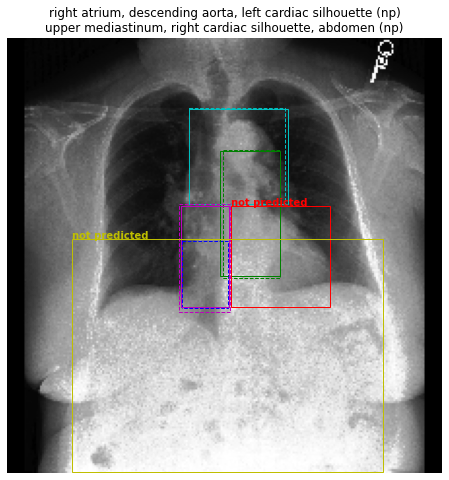

In [115]:
import matplotlib.pyplot as plt

def get_title(region_set, class_preds):
    # region_set always contains 6 region names
    # add a line break to the title, as to not make it too long
    # add "(np)" after region if it was not predicted
    region_set = [region if cls_pred else region + " (np)" for region, cls_pred in zip(region_set, class_preds)]
    return ", ".join(region_set[:3]) + "\n" + ", ".join(region_set[3:])

def plot_box(box, ax, clr, linestyle, class_pred=True):
    x0, y0, x1, y1 = box.tolist()
    h = y1 - y0
    w = x1 - x0
    ax.add_artist(
      plt.Rectangle(
          xy=(x0, y0),
          height=h,
          width=w,
          fill=False,
          color=clr,
          linewidth=1,
          linestyle=linestyle
      )
    )

regions_to_plot = region_set_6

fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
# fig, ax = plt.subplots(1, figsize=(8, 8))
plt.imshow(first_image.cpu().numpy().transpose(1, 2, 0), cmap='gray')
plt.axis('off')
colors = ["b", "g", "r", "c", "m", "y"]
class_preds = [True, True, False, True, True, False]
for region, color, cls_pred in zip(regions_to_plot, colors, class_preds):
    region_index = ANATOMICAL_REGIONS[region]

    box_gt = first_image_boxes[region_index]
    plot_box(box_gt, ax, clr=color, linestyle="solid", class_pred=cls_pred)

    if cls_pred:
        box_pred = first_image_pred_boxes[region_index]
        plot_box(box_pred, ax, clr=color, linestyle="dashed")

title = get_title(regions_to_plot, class_preds)
ax.set_title(title)

In [87]:
from src.dataset_bounding_boxes.constants import ANATOMICAL_REGIONS
region_set_1 = ["right lung", "right costophrenic angle", "left lung", "left costophrenic angle", "cardiac silhouette", "spine"]
region_set_2 = ["right upper lung zone", "right mid lung zone", "right lower lung zone", "left upper lung zone", "left mid lung zone", "left lower lung zone"]
region_set_3 = ["right hilar structures", "right apical zone", "right cardiophrenic angle", "left hilar structures", "left apical zone", "left cardiophrenic angle"]
region_set_4 = ["right hemidiaphragm", "left hemidiaphragm", "trachea", "right clavicle", "left clavicle", "aortic arch"]
region_set_5 = ["mediastinum", "left upper abdomen", "right upper abdomen", "svc", "cavoatrial junction", "carina"]
region_set_6 = ["right atrium", "descending aorta", "left cardiac silhouette", "upper mediastinum", "right cardiac silhouette", "abdomen"] 

In [86]:
all_regions = set()
all_region_sets = [region_set_1, region_set_2, region_set_3, region_set_4, region_set_5, region_set_6]

for region_set in all_region_sets:
    for reg in region_set:
        all_regions.add(reg)

print(len(all_regions))

36
